In [ ]:
# Execute this cell in clear env (e.x. colab)

!pip install networkx numpy scipy matplotlib
!mkdir -p dag-examples
!cd dag-examples && for i in `seq 1 2`; do wget https://github.com/NikitaSikalov/DataViz/raw/main/dag-examples/$i.xml; done

In [204]:
from typing import List, Set, Dict, Tuple, Union, Optional
from collections import defaultdict
from pathlib import Path
from uuid import uuid4
from itertools import permutations
from abc import abstractclassmethod, ABC

import networkx as nx
import numpy as np

from matplotlib import pyplot as plt
from scipy.optimize import linprog

In [26]:
def serialize_graph(path_: Path) -> Dict[str, Set[str]]:
    graph = dict()
    gr = nx.read_graphml(path_)
    for vertex in gr.nodes:
        graph[vertex] = set()
    
    for from_, to in gr.edges():
        graph[from_].add(to)

    return graph

In [292]:
Graph = Dict[str, Set[str]]
Coord = Tuple[int, int]


class DirGraph:
    def __init__(self, graph: Graph):
        self.graph: Graph = graph
        self.vertecies_coords: Optional[Dict[str, Coord]] = None
        self.vertecies_ids = {vertex: i for i, vertex in enumerate(graph)}
        self.dummy_vertecies: Optional[Set[str]] = None
        self._initial_graph = {vertex: neighbours.copy() for vertex, neighbours in graph.items()}

    def __len__(self):
        return len(self.graph)

    def __iter__(self):
        return iter(self.graph)

    def __getitem__(self, vertex: str) -> Set[str]:
        return self.graph[vertex]

    @property
    def vertecies(self) -> Set[str]:
        return {vertex for vertex in self.graph}

    @property
    def reversed_graph(self) -> Graph:
        reversed_graph: Dict[str, Set[str]] = {vertex: set() for vertex in self.graph}
        for vertex, neighbours in self.graph.items():
            for neighbour in neighbours:
                reversed_graph[neighbour].add(vertex)
        return reversed_graph

    @property
    def layers(self) -> Dict[int, Set[str]]:
        layers = defaultdict(set)
        for vertex, coords in self.vertecies_coords.items():
            _, y = coords
            layers[y].add(vertex)
        return layers

    @property
    def ordered_layers(self) -> Dict[int, List[str]]:
        ordered_layers = dict()
        for y_level, vertecies in self.layers.items():
            ordered_layers[y_level] = list(sorted(vertecies, key=lambda v: self.vertecies_coords[v][0]))
        return ordered_layers

    @property
    def with_dummy_vertecies(self) -> bool:
        return self.dummy_vertecies is not None

    @property
    def crossings_count(self) -> int:
        if not self.with_dummy_vertecies:
            raise TypeError('Dummy vertecies not initialized. Use .init_dummy_vertecies() to fix problem.')

        crossings = 0
        sorted_ordered_layers = self.get_sorted_ordered_layers_by_y(reverse=True)
        ordered_layers_pairs = zip(sorted_ordered_layers[:-1], sorted_ordered_layers[1:])
        for ordered_layer1, ordered_layer2 in ordered_layers_pairs:
            crossings += self._compute_crossings_count_between_layers(ordered_layer1, ordered_layer2)

        return crossings

    def layout(self, layout_method: 'Layout') -> None:
        self._reset_prev_layout()
        self.vertecies_coords = dict()
        layout_method(self)

    def draw(self, draw: 'DrawDag') -> None:
        draw(self)

    def ditribute_vertecies_along_layers(self) -> None:
        for y, vertecies in self.layers.items():
            for x, vertex in enumerate(sorted(vertecies, key=lambda u: self.vertecies_coords[u][0])):
                self.vertecies_coords[vertex] = (x, y)

    def init_dummy_vertecies(self) -> None:
        self.dummy_vertecies = set()
        graph_with_dummy: Graph = defaultdict(set)
        graph_with_dummy.update({vertex: neighbours.copy() for vertex, neighbours in self.graph.items()})

        for from_ in self.graph:
            x_from, y_from = self.vertecies_coords[from_]
            for to in self.graph[from_]:
                y_to = self.vertecies_coords[to][1]

                assert y_from > y_to, "Incorrect layout"

                if y_from - y_to == 1:
                    continue

                graph_with_dummy[from_].remove(to)
                tmp_dummy_vertecies = [str(uuid4()) for _ in range(y_to + 1, y_from)]
                vertecies_with_dummy = [from_] + tmp_dummy_vertecies + [to]
                edges_with_dummy = zip(vertecies_with_dummy[:-1], vertecies_with_dummy[1:])
                for dummy_from, dummy_to in edges_with_dummy:
                    graph_with_dummy[dummy_from].add(dummy_to)
                for i, dummy_vertex in enumerate(tmp_dummy_vertecies):
                    self.vertecies_coords[dummy_vertex] = (x_from, y_from - i - 1)

                self.dummy_vertecies |= set(tmp_dummy_vertecies)

        self.graph = graph_with_dummy
        self.ditribute_vertecies_along_layers()

    def get_sorted_ordered_layers_by_y(self, reverse: bool = False) -> List[List[str]]:
        return [vertecies for _, vertecies in sorted(self.ordered_layers.items(), key=lambda layer: layer[0], reverse=reverse)]

    def minimize_crossings_count(self) -> None:
        sorted_ordered_layers = self.get_sorted_ordered_layers_by_y(reverse=True)
        layers_pairs = zip(sorted_ordered_layers[:-1], sorted_ordered_layers[1:])
        while True:
            prev_crossings_count = self.crossings_count
            for i, (ordered_layer1, ordered_layer2) in enumerate(layers_pairs):
                ordered_layer3 = sorted_ordered_layers[i + 1] if i + 1 < len(sorted_ordered_layers) else None

                permutations_list: List[Tuple[int, List[str]]] = []
                for layer2_permutation in permutations(ordered_layer2):
                    permutation_crossing = self._compute_crossings_count_between_layers(ordered_layer1, layer2_permutation)
                    if ordered_layer3:
                        permutation_crossing += self._compute_crossings_count_between_layers(ordered_layer2, ordered_layer3)
                    permutations_list.append((permutation_crossing, layer2_permutation))

                _, optimal_permutation = min(permutations_list, key=lambda x: x[0])
                for x, vertex in enumerate(optimal_permutation):
                    _, y = self.vertecies_coords[vertex]
                    self.vertecies_coords[vertex] = (x, y)

            if self.crossings_count == prev_crossings_count:
                break

    def items(self):
        return self.graph.items()

    def _compute_crossings_count_between_layers(self, ordered_layer1: Union[List[str], Tuple[str]], ordered_layer2: Union[List[str], Tuple[str]]) -> int:
        crossings = 0
        for i, v1 in enumerate(ordered_layer1):
            for v2 in ordered_layer1[i + 1:]:
                for v1_neighbour in (self.graph[v1] & set(ordered_layer2)):
                    for v2_neighbour in (self.graph[v2] & set(ordered_layer2)):
                        x1 = ordered_layer2.index(v1_neighbour)
                        x2 = ordered_layer2.index(v2_neighbour)
                        if x2 < x1:
                            crossings += 1

        return crossings

    def _reset_prev_layout(self) -> None:
        self.vertecies_coords = None
        self._clear_dummy_vertecies()

    def _clear_dummy_vertecies(self) -> None:
        if not self.with_dummy_vertecies:
            return
        self.graph = {vertex: neighbours.copy() for vertex, neighbours in self._initial_graph.items()}
        self.dummy_vertecies = None 

In [293]:
class DrawDag:
    def __init__(self, title: Optional[str] = None, figsize: Tuple[int, int] = (12, 8)):
        self.title = title
        self.figsize = figsize
        self._graph = None

    def __call__(self, graph: DirGraph):
        self._graph = graph

        plt.figure(figsize=self.figsize)
        if self.title:
            plt.title(self.title)
        plt.grid()
        for vertex in graph:
            neighbours = graph[vertex]
            if not neighbours:
                self.draw_vertex(vertex, graph.vertecies_coords[vertex])
            else:
                for neighbour in neighbours:
                    self.draw_arrow((vertex, graph.vertecies_coords[vertex]), (neighbour, graph.vertecies_coords[neighbour]))

    def draw_arrow(self, from_: Tuple[str, Tuple[int, int]], to_: Tuple[str, Tuple[int, int]]):
        from_label, from_coords = from_[0], from_[1]
        to_label, to_coords = to_[0], to_[1]

        k = 1.0
        delta = (to_coords[0] - from_coords[0]) * k, (to_coords[1] - from_coords[1]) * k

        plt.arrow(*from_coords, *delta, head_width=0.05, head_length=0.05, fc='none', ec='k')
        if not self._graph.with_dummy_vertecies or from_label not in self._graph.dummy_vertecies:
            self.draw_vertex(from_label, from_coords)
        if not self._graph.with_dummy_vertecies or to_label not in self._graph.dummy_vertecies:
            self.draw_vertex(to_label, to_coords)

    @staticmethod
    def draw_vertex(label: str, coords: Tuple[int, int]):
        plt.scatter(*coords, s=200, facecolors='none', edgecolors='r')
        plt.annotate(label, coords, textcoords="offset points", xytext=(20, 0), ha='right')

In [294]:
class Layout(ABC):
    def __call__(self, graph: DirGraph) -> None:
        self.layout(graph)

    @abstractclassmethod
    def layout(self, graph: DirGraph) -> None:
        pass

In [295]:
class MaxWidthLayout(Layout):
    def __init__(self, max_width: Optional[int] = None):
        self.max_width = max_width

    def layout(self, graph: DirGraph) -> None:
        # According to Coffman Graham algo
        vertecies_order = self._top_sort(graph)
        unplaced_vertecies = graph.vertecies
        k = 1
        current_layer: Set[str] = set()

        while unplaced_vertecies:
            vertecies_with_placed_neighbours = [vertex for vertex in unplaced_vertecies if not (graph[vertex] & unplaced_vertecies)]

            for next_vertex in sorted(vertecies_with_placed_neighbours, key=lambda v: vertecies_order[v]):
                if not (graph[next_vertex] & current_layer):
                    break

            if len(current_layer) == self.max_width or (graph[next_vertex] & current_layer):
                current_layer = set()
                k += 1

            graph.vertecies_coords[next_vertex] = (len(current_layer), k)
            current_layer.add(next_vertex)
            unplaced_vertecies.remove(next_vertex)

    @staticmethod
    def _top_sort(graph: DirGraph) -> Dict[str, int]:
        orders_dict: Dict[str, List[int]] = dict()
        vertecies_orders: Dict[str, int] = dict()
        vertecies_count = len(graph)
        max_order = vertecies_count + 1

        # init orders by default max_order
        for vertex in graph:
            orders_dict[vertex] = []
            vertecies_orders[vertex] = max_order
        for vertex, neighbours in graph.items():
            for neighbour in neighbours:
                orders_dict[neighbour].append(max_order)

        # compute orders
        for order in range(vertecies_count):
            next_vertex, _ = min(orders_dict.items(), key=lambda x: list(sorted(x[1], reverse=True)))
            del orders_dict[next_vertex]
            vertecies_orders[next_vertex] = order
            for neighbour in graph[next_vertex]:
                orders_dict[neighbour] = [vertecies_orders[v] for v in graph.reversed_graph[neighbour]]

        return vertecies_orders

In [296]:
class MinDummyVerteciesLayout(Layout):
    def __init__(self, minimize_crossings: bool = True):
        self.minimize_crossings = minimize_crossings

    def layout(self, graph: DirGraph) -> None:
        vertecies_count = len(graph)
        # Linear programming problem
        c = np.zeros(vertecies_count)
        A = None
        for from_ in graph:
            for to in graph[from_]:
                c[graph.vertecies_ids[from_]] += 1
                c[graph.vertecies_ids[to]] -= 1
                column = np.zeros(vertecies_count)
                column[graph.vertecies_ids[from_]] = -1
                column[graph.vertecies_ids[to]] = 1
                if A is None:
                    A = column
                else:
                    A = np.vstack((A, column))

        assert A.shape[1] == vertecies_count

        b = np.array([-1 for _ in range(A.shape[0])])

        bounds = [(0, None) for _ in range(vertecies_count)]
        result = linprog(c, A_ub=A, b_ub=b, bounds=bounds)

        assert len(result.x) == vertecies_count

        y_real_vector = result.x
        y_real = {vertex: y_real_vector[graph.vertecies_ids[vertex]] for vertex in graph}
        real_layers = sorted(y_real.items(), key=lambda x: x[1])

        y_coords: Dict[str, int] = dict()
        for vertex, y_layer in real_layers:
            placed_neighbours = [u for u in graph[vertex] if u in y_coords]
            if placed_neighbours:
                max_y_descendant = max([y_coords[u] for u in placed_neighbours])
                y_vertex = max_y_descendant + 1
            else:
                y_vertex = int(y_real[vertex])

            y_coords[vertex] = y_vertex

        for vertex, y in y_coords.items():
            graph.vertecies_coords[vertex] = (0, y)

        graph.init_dummy_vertecies()
        graph.ditribute_vertecies_along_layers()

        if self.minimize_crossings:
            graph.minimize_crossings_count()

In [297]:
# Graph example (from book)

graph_example: Graph = dict()
graph_example["a"] = {"d", "e"}
graph_example["b"] = set()
graph_example["c"] = {"g"}
graph_example["d"] = {"c", "i", "h"}
graph_example["e"] = {"i", "f", "j", "g"}
graph_example["f"] = set()
graph_example["g"] = {"k"}
graph_example["h"] = {"k", "l"}
graph_example["i"] = {"h"}
graph_example["j"] = {"l"}
graph_example["k"] = {"m"}
graph_example["l"] = {"m"}
graph_example["m"] = set()

dir_graph = DirGraph(graph_example)

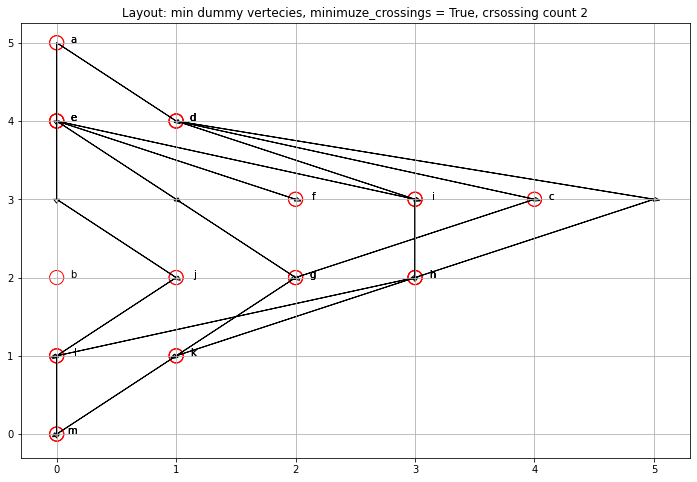

In [220]:
dir_graph.layout(MinDummyVerteciesLayout(minimize_crossings=True))
dir_graph.draw(DrawDag(title=f"Layout: min dummy vertecies, minimuze_crossings = True, crsossing count {dir_graph.crossings_count}"))

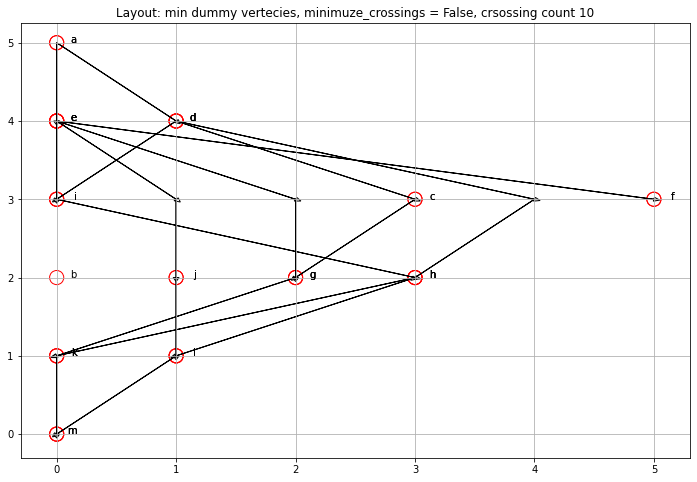

In [222]:
dir_graph.layout(MinDummyVerteciesLayout(minimize_crossings=False))
dir_graph.draw(DrawDag(title=f"Layout: min dummy vertecies, minimuze_crossings = False, crsossing count {dir_graph.crossings_count}"))

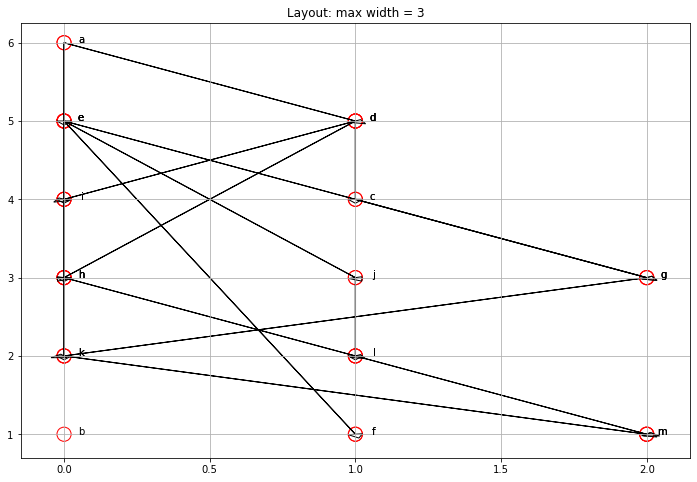

In [305]:
max_width = 3

dir_graph.layout(MaxWidthLayout(max_width=3))
dir_graph.draw(DrawDag(title=f"Layout: max width = {max_width}"))

In [310]:
# Litle bit more complex exmple

dir_graph = DirGraph(serialize_graph("./dag-examples/1.xml"))

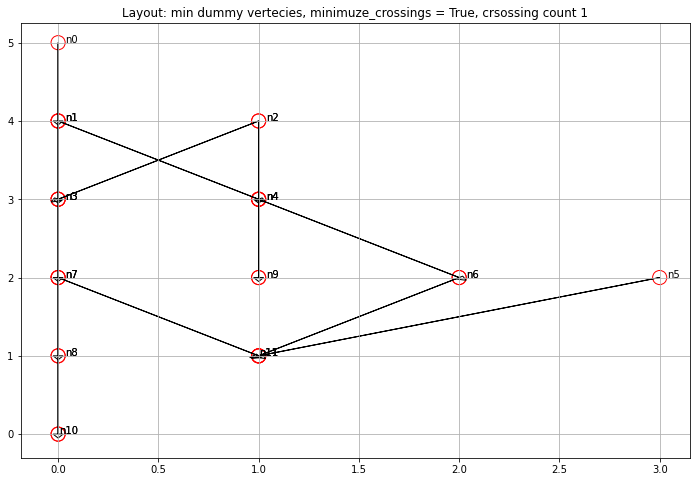

In [311]:
minimize_crossings = True
dir_graph.layout(MinDummyVerteciesLayout(minimize_crossings=minimize_crossings))
dir_graph.draw(DrawDag(title=f"Layout: min dummy vertecies, minimuze_crossings = {minimize_crossings}, crsossing count {dir_graph.crossings_count}"))

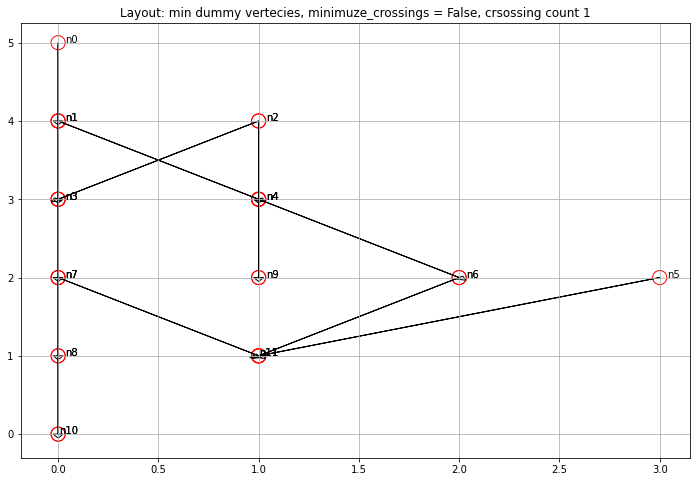

In [312]:
minimize_crossings = False
dir_graph.layout(MinDummyVerteciesLayout(minimize_crossings=minimize_crossings))
dir_graph.draw(DrawDag(title=f"Layout: min dummy vertecies, minimuze_crossings = {minimize_crossings}, crsossing count {dir_graph.crossings_count}"))

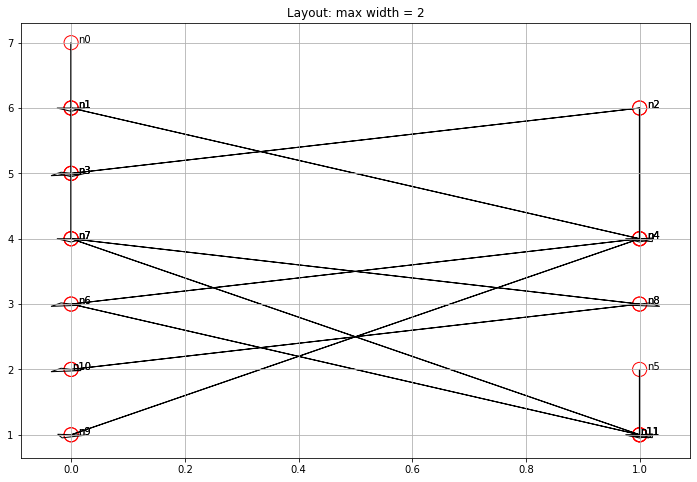

In [314]:
max_width = 2

dir_graph.layout(MaxWidthLayout(max_width=2))
dir_graph.draw(DrawDag(title=f"Layout: max width = {max_width}"))

In [306]:
# More complex examples

dir_graph = DirGraph(serialize_graph("./dag-examples/2.xml"))

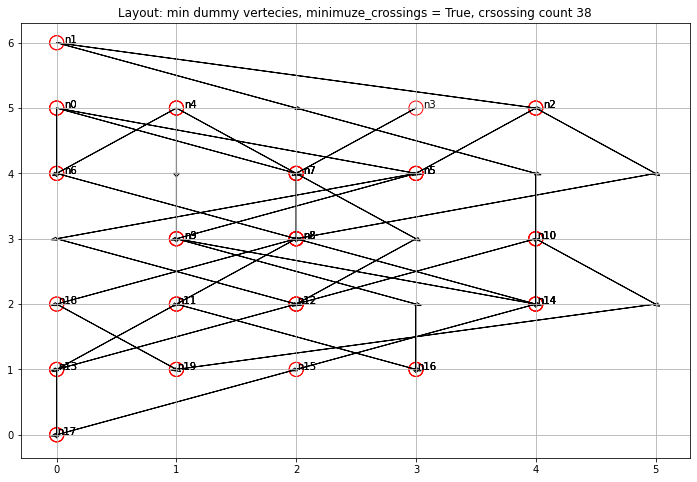

In [307]:
minimize_crossings = True
dir_graph.layout(MinDummyVerteciesLayout(minimize_crossings=minimize_crossings))
dir_graph.draw(DrawDag(title=f"Layout: min dummy vertecies, minimuze_crossings = True, crsossing count {dir_graph.crossings_count}"))

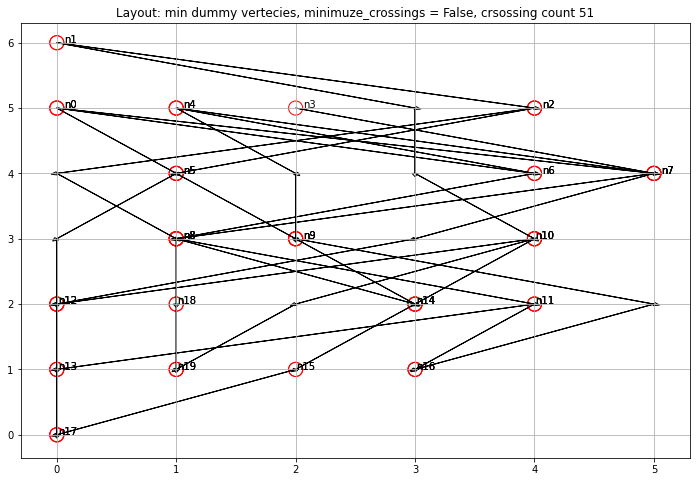

In [308]:
minimize_crossings = False
dir_graph.layout(MinDummyVerteciesLayout(minimize_crossings=minimize_crossings))
dir_graph.draw(DrawDag(title=f"Layout: min dummy vertecies, minimuze_crossings = {minimize_crossings}, crsossing count {dir_graph.crossings_count}"))

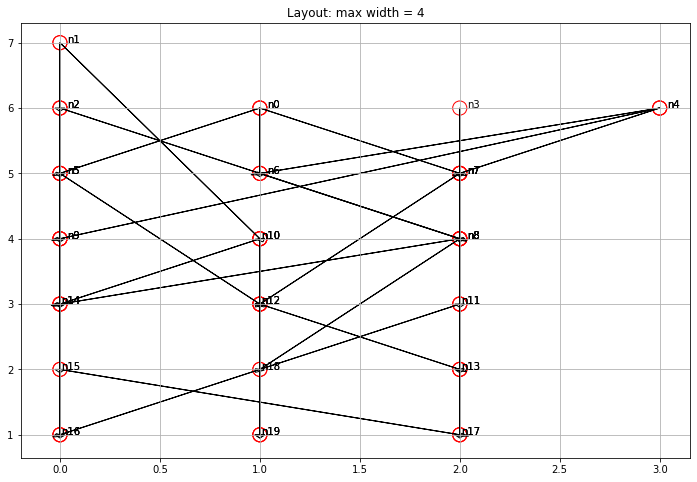

In [309]:
max_width = 4

dir_graph.layout(MaxWidthLayout(max_width=max_width))
dir_graph.draw(DrawDag(title=f"Layout: max width = {max_width}"))